# MACHINE LERNING FOR DRAWINGS CLASSIFICATION
### IMPLEMENTATION OF A KERNEL SVM FOR MULTICLASS CLASSIFICATION

First we import all libraries we will need along the project

In [ ]:
import urllib.request
import os 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import pandas as pd
import errno
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns

%matplotlib inline

We used a function found at a [Github repository](https://github.com/zaidalyafeai/QuickDraw10/blob/master/quick_draw10.py) and made by user [Zaid Alyafeai](https://github.com/zaidalyafeai) that downloaded the dataset to our computer and then laods it to the notebook.

In [ ]:
def download_and_load(test_split = 0.2, max_items_per_class = 10000):
    root = 'data'
    try:
        os.mkdir(root)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass   
    print('downloading ...')
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in class_names:
        path = base+c+'.npy'
        print(path)
        urllib.request.urlretrieve(path, f'{root}/{c}.npy')
    print('loading ...')
  
    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    
    #load each data file 
    for idx, file in enumerate(class_names):
        data = np.load(f'{root}/{file}.npy')
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

    data = None
    labels = None

    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #reshape and inverse the colors 
    x = 255 - np.reshape(x, (x.shape[0], 28, 28))

    #separate into training and testing 
    test_size  = int(x.shape[0]/100*(test_split*100))

    x_test = x[0:test_size, :]
    y_test = y[0:test_size]

    x_train = x[test_size:x.shape[0], :]
    y_train = y[test_size:y.shape[0]]
  
    print('Training Data : ', x_train.shape[0])
    print('Testing  Data : ', x_test.shape[0])
    return x_train, y_train, x_test, y_test, class_names

At this part we can select what will be the words that our model will have to classify. The options in the are indicated in the following link https://github.com/googlecreativelab/quickdraw-dataset/blob/master/categories.txt

Notice that you can select as many as you want, but the more you choose, the higher the computational cost.

In [ ]:
class_names = ['cloud','sun', 'umbrella', 'eyeglasses']
#,'pants',,'table','ladder','eyeglasses','clock','scissors','cup'] 

# Download and load the selected categories and building the dataframes:

Select number of items per class on the first line:

In [ ]:
x_train, y_train, x_test, y_test, class_names = download_and_load(max_items_per_class = 10000)

x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
data = []
for label in range(0, len(class_names)):
    for img in  x[y == label]:
        img = img.astype(int)
        for i in range(0, len(img)):
            for j in range(0, len(img[i])):
                if (img[i][j] > 127):
                    img[i][j] = 0
                else:
                    img[i][j] = 1
        data.append([class_names[label]]+img.flatten().tolist())
column_names = ["label"]
for i in range(0, 784):
    column_names.append(str(i))
dataset = pd.DataFrame(data, columns=column_names) 
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

downloading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cloud.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/umbrella.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
loading ...
Training Data :  32000
Testing  Data :  8000


,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,eyeglasses,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,umbrella,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,sun,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,umbrella,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,umbrella,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
len(dataset)

40000

In [ ]:
dataset_mini = dataset.iloc[0:2000,:]
X = dataset_mini.iloc[:,1:].values
y = dataset_mini.iloc[:,0].values
len(X)

2000

# Tuning the hyper-parameters of our estimator

Exhaustive Grid Search

In [ ]:
parameters = [
  {'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
    {'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['poly']},
 ]
model = SVC()
clf = GridSearchCV(model, parameters)
grid = clf.fit(X, y)

In [ ]:
result = pd.DataFrame(grid.cv_results_)
result.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.188692,0.007492,0.039595,0.002325,1,1,linear,"{'C': 1, 'gamma': 1, 'kernel': 'linear'}",0.835,0.835,0.8375,0.85,0.845,0.8405,0.006,25
1,0.198094,0.007209,0.039309,0.001683,1,0.1,linear,"{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}",0.835,0.835,0.8375,0.85,0.845,0.8405,0.006,25
2,0.191025,0.009334,0.038723,0.001047,1,0.01,linear,"{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}",0.835,0.835,0.8375,0.85,0.845,0.8405,0.006,25
3,0.194396,0.006674,0.038751,0.001106,1,0.001,linear,"{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}",0.835,0.835,0.8375,0.85,0.845,0.8405,0.006,25
4,0.189921,0.010017,0.038875,0.000889,1,0.0001,linear,"{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}",0.835,0.835,0.8375,0.85,0.845,0.8405,0.006,25


**Overview of the results:**

In [ ]:
import altair as alt

result = result[["mean_test_score", "param_C", "param_gamma", "param_kernel"]]

poly = alt.Chart(result[result["param_kernel"]=='poly']).mark_rect().encode(
    x='param_gamma:O',
    y='param_C:O',
    color=alt.Color('mean_test_score:Q', scale=alt.Scale(domain=[0.2,1]))
)
rbf = alt.Chart(result[result["param_kernel"]=='rbf']).mark_rect().encode(
    x='param_gamma:O',
    y='param_C:O',
    color=alt.Color('mean_test_score:Q', scale=alt.Scale(domain=[0.2,1]))
)
linear = alt.Chart(result[result["param_kernel"]=='linear']).mark_rect().encode(
    x='param_gamma:O',
    y='param_C:O',
    color=alt.Color('mean_test_score:Q', scale=alt.Scale(domain=[0.2,1]))
).properties(
    width=200,
    height=150,
    title='Model Accuracy for Linear Kernel'
)
poly.properties(
    width=200,
    height=150,
    title='Model Accuracy for Polynomial Kernel'
)|rbf.properties(
    width=200,
    height=150,
    title='Model Accuracy for RBF Kernel'
)|linear

alt.HConcatChart(...)

**Top 5 best performing hyperparameters:**

In [ ]:
result.sort_values('mean_test_score', ascending=False).head(5)

,mean_test_score,param_C,param_gamma,param_kernel
51,0.9255,100,0.1,poly
55,0.9255,1000,1,poly
56,0.9255,1000,0.1,poly
57,0.9255,1000,0.01,poly
40,0.9255,1,1,poly


**Winner:** 

   Kernel RBF, C = 1, $\gamma$ = 0.01

# Select hyperparameters kernel, C, Gamma according to the results

In [ ]:
from IPython.display import display
from ipywidgets import Dropdown

choose_kernel = Dropdown(
    options=[('rbf', 'rbf'), ('linear', 'linear'), ('poly', 'poly')],
    value='poly',
    description='Kernel:',
)

choose_C = Dropdown(
    options=[('1', 1), ('10', 10), ('100', 100), ('1000',1000)],
    value=100,
    description='C:',
)
choose_gamma = Dropdown(
    options=[('1', 1), ('0.1', 0.1), ('0.01', 0.01),('0.001', 0.001),('0.0001', 0.0001)],
    value=0.1,
    description='Gamma:',
)

In [ ]:
choose_kernel

Dropdown(description='Kernel:', index=2, options=(('rbf', 'rbf'), ('linear', 'linear'), ('poly', 'poly')), val…

In [ ]:
choose_C

Dropdown(description='C:', index=2, options=(('1', 1), ('10', 10), ('100', 100), ('1000', 1000)), value=100)

In [ ]:
choose_gamma

Dropdown(description='Gamma:', index=1, options=(('1', 1), ('0.1', 0.1), ('0.01', 0.01), ('0.001', 0.001), ('0…

In [ ]:
print("Your selection: (K: ",choose_kernel.value, ", C: ",choose_C.value, ", Gamma: ",choose_gamma.value,")", sep="")

Your selection: (K: poly, C: 100, Gamma: 0.1)


# NOW THAT WE HAVE CHOSEN THE HYPERPARAMETERS LETS TRAIN AND TEST OUR FINAL MODEL

We divide our set in train 75% and test 25%:

/home/gonzalo/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

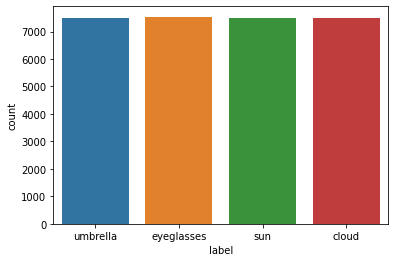

In [ ]:
X = dataset.iloc[:,1:]
y = dataset.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
sns.countplot(y_train)

We normalize the data for better results:

In [ ]:
sc_X = StandardScaler()
y_testsc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)

In [ ]:
X_test.reset_index(inplace=True, drop=True)
X_test_norm = sc_X.transform(X_test)
y_test.reset_index(inplace=True, drop=True)

Now we define our classifier and train the model:

In [ ]:
print('SVM Classifier with gamma = 0.01; Kernel = RBF: C = 100')
classifier = SVC(C=choose_C.value, gamma=choose_gamma.value, kernel=choose_kernel.value, random_state = 0)
classifier.fit(X_train,y_train)

SVM Classifier with gamma = 0.01; Kernel = RBF: C = 100


SVC(C=100, gamma=0.1, kernel='poly', random_state=0)

Lets then predict the test:

In [ ]:
y_pred = classifier.predict(X_test_norm)

### 1.2 Performance Evaluation
#### Calculate the Model Accuracy and Confusion Matrix

In [ ]:
model_acc = classifier.score(X_test_norm, y_test)
test_acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test,y_pred)

In [ ]:
print('\nSVM Trained Classifier Accuracy: ', model_acc)
print('\nPredicted Values: ',y_pred[0:5], "...")
print('\nAccuracy of Classifier on Validation Images: ',test_acc)
print('\nConfusion Matrix: \n',conf_mat)


SVM Trained Classifier Accuracy:  0.9492

Predicted Values:  ['cloud' 'cloud' 'sun' 'eyeglasses' 'eyeglasses'] ...

Accuracy of Classifier on Validation Images:  0.9492

Confusion Matrix: 
 [[2291  114   58   39]
 [  49 2333   60   19]
 [  27   37 2444   11]
 [  11   22   61 2424]]


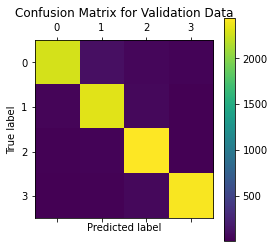

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(conf_mat)
plt.title('Confusion Matrix for Validation Data')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Visualize some Sample Image Prediction from 5 random ' test ' samples**

In [ ]:
X_test = X_test.to_numpy()
y_test= y_test.to_numpy()

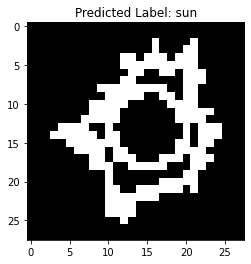

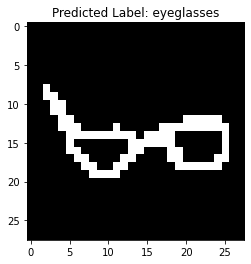

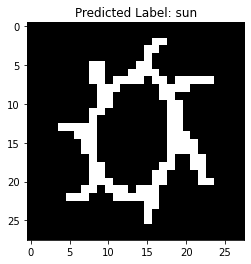

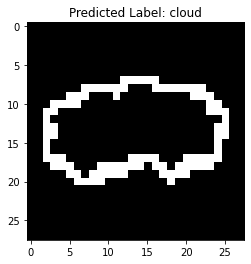

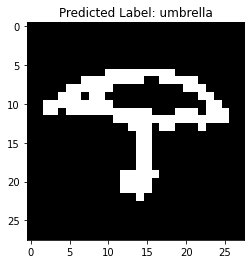

In [ ]:
a = np.random.randint(1,10000,5)
for i in a:
    two_d = (np.reshape(X_test[i], (28, 28)) * 255).astype(np.uint8)
    plt.title('Predicted Label: {0}'.format(y_pred[i]))
    plt.imshow(two_d, interpolation='nearest',cmap='gray')
    plt.show()